# 1. Download and unzip data

In [42]:
# !wget https://isic-challenge-data.s3.amazonaws.com/2016/ISBI2016_ISIC_Part3_Training_Data.zip
# !wget https://isic-challenge-data.s3.amazonaws.com/2016/ISBI2016_ISIC_Part3_Test_Data.zip
# !wget https://isic-challenge-data.s3.amazonaws.com/2016/ISBI2016_ISIC_Part3_Training_GroundTruth.csv
# !wget https://isic-challenge-data.s3.amazonaws.com/2016/ISBI2016_ISIC_Part3_Test_GroundTruth.csv

In [43]:
# !unzip "./ISBI2016_ISIC_Part3_Test_Data.zip"
# !unzip "./ISBI2016_ISIC_Part3_Training_Data.zip"

In [44]:
import os
import shutil
import pandas as pd
import numpy as np

# 2. Make training, validation and test image folders by training and test csv files
[ImageFolder](https://pytorch.org/vision/main/generated/torchvision.datasets.ImageFolder.html)

In [45]:
""" Create Directories """
# train
os.makedirs('./train', exist_ok=True)
os.makedirs('./train/benign', exist_ok=True)
os.makedirs('./train/malignant', exist_ok=True)
# validation
os.makedirs('./val', exist_ok=True)
os.makedirs('./val/benign', exist_ok=True)
os.makedirs('./val/malignant', exist_ok=True)
# test
os.makedirs('./test', exist_ok=True)
os.makedirs('./test/benign', exist_ok=True)
os.makedirs('./test/malignant', exist_ok=True)



df = pd.read_csv("./ISBI2016_ISIC_Part3_Training_GroundTruth.csv")
img_lis = []
lbl_lis = []
img_lis.append("ISIC_0000000")
lbl_lis.append("benign")
for i in range(len(df)):
    name, label = df["ISIC_0000000"][i], df["benign"][i]
    img_lis.append(name)
    lbl_lis.append(label)
N_train_val = len(img_lis)
N_train = int(N_train_val * 0.8)
print(N_train_val)
print(N_train)
shuffle_ix = np.random.permutation(np.arange(N_train_val))
ix_train = shuffle_ix[:N_train]
ix_val = shuffle_ix[N_train:]
for i in ix_train:
    name, label = img_lis[i], lbl_lis[i]
    shutil.copy("./ISBI2016_ISIC_Part3_Training_Data/"+name+".jpg", "./train/"+label+"/"+name+".jpg")
for i in ix_val:
    name, label = img_lis[i], lbl_lis[i]
    shutil.copy("./ISBI2016_ISIC_Part3_Training_Data/"+name+".jpg", "./val/"+label+"/"+name+".jpg")

if not os.path.exists("./test"):
    os.makedirs("./test")
    os.makedirs("./test/benign")
    os.makedirs("./test/malignant")
df = pd.read_csv("./ISBI2016_ISIC_Part3_Test_GroundTruth.csv")
shutil.copy("./ISBI2016_ISIC_Part3_Test_Data/ISIC_0000003.jpg", "./test/benign/ISIC_0000003.jpg")
for i in range(len(df)):
    name, label = df["ISIC_0000003"][i], df["0.0"][i]
    label = "benign" if label == 0 else "malignant"
    shutil.copy("./ISBI2016_ISIC_Part3_Test_Data/"+name+".jpg", "./test/"+label+"/"+name+".jpg")

900
720


# 3. Prepare data and build dataloaders

Fourier-based Transformation

In [46]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from PIL import Image
import numpy as np

# Fourier Transformation Functions
def fft_shift(image):
    return np.fft.fftshift(np.fft.fft2(image))

def ifft_shift(image):
    return np.fft.ifft2(np.fft.ifftshift(image)).real

def random_phase_shift(image):
    image_fft = fft_shift(image)
    magnitude = np.abs(image_fft)
    phase = np.angle(image_fft)
    random_shift = np.random.uniform(-np.pi, np.pi, phase.shape)
    phase_shifted = phase + random_shift
    new_fft = magnitude * np.exp(1j * phase_shifted)
    new_image = ifft_shift(new_fft)
    return new_image

class FourierTransform(object):
    def __call__(self, image):
        image_np = np.array(image)
        if image_np.ndim == 3:
            channels = []
            for i in range(3):
                channel = image_np[:,:,i]
                channel_augmented = random_phase_shift(channel)
                channels.append(channel_augmented)
            image_np = np.stack(channels, axis=-1)
        else:
            image_np = random_phase_shift(image_np)
        return Image.fromarray(np.uint8(image_np.clip(0, 255)))

In [47]:
from torchvision.datasets import ImageFolder
from torchvision import transforms
import torch


root_train, root_val, root_test = './train', './val', './test'

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomVerticalFlip(),       # using stronger augmentation functions to enhance performance or solve LT problem
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.5, contrast=1, saturation=0.1, hue=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

fourier_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    # transforms.RandomVerticalFlip(),       # using stronger augmentation functions to enhance performance or solve LT problem
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.5, contrast=1, saturation=0.1, hue=0.5),
    FourierTransform(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


def get_train_test_set(batch_size):
    augmented_train_dataset = ImageFolder(root_train, transform=fourier_transform)
    original_train_dataset = ImageFolder(root_train, transform=test_transform)


    loader_train_original = torch.utils.data.DataLoader(
        dataset=original_train_dataset,
        batch_size=batch_size,
        shuffle=True
        )

    loader_train_augmented = torch.utils.data.DataLoader(
        dataset=augmented_train_dataset,
        batch_size=batch_size,
        shuffle=True
        )

    val_dataset = ImageFolder(root_val, transform=test_transform)
    loader_val = torch.utils.data.DataLoader(
        dataset=val_dataset,
        batch_size=batch_size,
        shuffle=False
        )

    test_dataset = ImageFolder(root_test, transform=test_transform)
    loader_test = torch.utils.data.DataLoader(
        dataset=test_dataset,
        batch_size=batch_size,
        shuffle=False
        )

    return loader_train_original, loader_train_augmented, loader_val, loader_test

batch_size = 16
loader_train, loader_augmented, loader_val, loader_test = get_train_test_set(batch_size)

# 4. Build the network

## Implement ResNet50

In [48]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import resnet50

class Bottleneck(nn.Module):
    '''
    The single block in ResNet
    '''
    expansion = 4
    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.conv3(out)
        out = self.bn3(out)
        if self.downsample is not None:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, layers, use_fc=False, dropout=None):
        self.inplanes = 64
        super(ResNet, self).__init__()

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # stacking layers
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        self.avgpool = nn.AvgPool2d(7, stride=1)

        self.use_fc = use_fc
        self.use_dropout = True if dropout else False
        if self.use_fc:
            print('Using fc.')
            self.fc_add = nn.Linear(512*block.expansion, 512)
        if self.use_dropout:
            print('Using dropout.')
            self.dropout = nn.Dropout(p=dropout)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        '''
        Buiding ResNet layer by stacking blocks
        '''
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))
        return nn.Sequential(*layers)

    def forward(self, x, *args):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = x.mean(dim=(-2, -1))
        x = x.view(x.size(0), -1)
        if self.use_fc:
            x = F.relu(self.fc_add(x))
        if self.use_dropout:
            x = self.dropout(x)
        return x

def get_resnet50(pre_trained=True):
    Resnet50 = ResNet(Bottleneck, [3, 4, 6, 3], dropout=None)
    if pre_trained:
        pre_trained = resnet50(weights = "IMAGENET1K_V2").state_dict()
        new_weights = {k: pre_trained[k] for k in Resnet50.state_dict()}
        Resnet50.load_state_dict(new_weights)
    return Resnet50

## Create Teacher Student Models

In [49]:
class ClassificationModel(nn.Module):
    def __init__(self, encoder, num_classes=1):
        super(ClassificationModel, self).__init__()
        self.encoder = encoder
        self.classifier = nn.Linear(2048, num_classes)
    def forward(self, x):
        x = self.encoder(x)
        x = self.classifier(x)
        return x

resnet50 = get_resnet50(pre_trained=True)
student_model = ClassificationModel(resnet50, 1)
teacher1_model = ClassificationModel(resnet50, 1)
teacher2_model = ClassificationModel(resnet50, 1)

### 5. Train and test your model

In [50]:
from torchvision.datasets import ImageFolder
from torchvision import transforms
import torch
from tqdm import tqdm
import numpy as np
import torch.nn as nn
from sklearn.metrics import roc_auc_score, accuracy_score

In [51]:
import gc
# reset GPU memory if needed
def reset_gpu_mem():
    gc.collect()
    torch.cuda.empty_cache()

In [52]:
reset_gpu_mem

<function __main__.reset_gpu_mem()>

In [53]:
max_epoch = 10
use_cuda = torch.cuda.is_available()
if use_cuda:
    student_model = student_model.cuda()
    teacher1_model = teacher1_model.cuda()
    teacher2_model = teacher2_model.cuda()
    
criterion = nn.CrossEntropyLoss()
# criterion = nn.BCELoss()
optimizer = torch.optim.SGD(student_model.parameters(), lr=0.01, momentum=0.9)

loss_list, val_loss_list = [], [] # record the training loss
auc_train_list, acc_train_list = [], [] # record the training metrics
auc_val_list, acc_val_list = [], [] # record the validation metrics

for epoch in range(max_epoch):
    print(" -- Epoch {}/{}".format(epoch + 1, max_epoch))

    ### training the model
    student_model.train()
    running_loss = 0.0
    train_lbl = []
    train_pred = []
    for data, augmented_data in zip(loader_train, loader_augmented):
        optimizer.zero_grad()
        images, labels = data
        labels = labels.float()
        if use_cuda:
            images = images.cuda()
            labels = labels.float().cuda()

        augmented_images, augmented_labels = augmented_data
        augmented_labels = augmented_labels.float()
        if use_cuda:
            augmented_images = augmented_images.cuda()
            augmented_labels = augmented_labels.float().cuda()

        # Get teacher outputs
        with torch.no_grad():
            teacher_outputs1 = teacher1_model(augmented_images)[:,0]
            teacher_outputs1 = torch.sigmoid(teacher_outputs1)
            teacher_outputs2 = teacher2_model(augmented_images)[:,0]
            teacher_outputs2 = torch.sigmoid(teacher_outputs2)

        # Get student outputs on both original and augmented
        student_original_outputs = student_model(images)[:,0]
        student_original_outputs = torch.sigmoid(student_original_outputs)
        student_augmented_outputs = student_model(augmented_images)[:,0]
        student_augmented_outputs = torch.sigmoid(student_augmented_outputs)

        # student loss original
        student_original_loss = criterion(student_original_outputs, labels)
        # student loss augmented
        student_augmented_loss = criterion(student_augmented_outputs, augmented_labels)

        # regularization loss
        reg_loss = criterion(student_original_outputs, teacher_outputs1) + criterion(student_original_outputs, teacher_outputs2)
        
        # total loss
        total_loss = student_original_loss + 0.5 * student_augmented_loss + 0.5 * reg_loss

        total_loss.backward()
        optimizer.step()

        running_loss += total_loss.item()
        train_lbl += list(labels.detach().cpu().numpy())
        train_pred += list(student_original_outputs.detach().cpu().numpy())
        

    ### record the training loss and metrics
    # -- write your codes here
    loss = running_loss / (len(loader_train) + len(loader_augmented))
    loss_list.append(loss)
    train_lbl, train_pred = np.array(train_lbl), np.array(train_pred)
    train_pred_lbl = np.around(train_pred) # pred >= 0.5 pred_lbl = 1 else pred_lbl = 0
    train_auc = roc_auc_score(train_lbl, train_pred)
    train_acc = accuracy_score(train_lbl, train_pred_lbl)
    auc_train_list.append(train_auc)
    acc_train_list.append(train_acc)


    ### evaluate on validation set
    student_model.eval()
    val_lbl, val_pred = [], []
    val_loss = 0.0
    for data in loader_val:
        val_images, val_labels = data
        val_labels = val_labels.float()
        if use_cuda:
            val_images = val_images.cuda()
            val_labels = val_labels.float().cuda()
        with torch.no_grad():
            val_outputs = student_model(val_images)[:, 0]
        val_outputs = torch.sigmoid(val_outputs)
        y_scores = list(val_outputs.detach().cpu().numpy())
        y_true = list(val_labels.detach().cpu().numpy())
        val_lbl += y_true
        val_pred += y_scores
        
        v_loss = criterion(val_outputs, val_labels)
        # v_loss = focal_loss.sigmoid_focal_loss(val_outputs, val_labels, reduction='mean')
        val_loss += v_loss.item()

    ### record the validation loss and metrics, save the best checkpoint
    val_lbl, val_pred = np.array(val_lbl), np.array(val_pred)
    val_pred_lbl = np.around(val_pred) # pred >= 0.5 pred_lbl = 1 else pred_lbl = 0
    val_auc = roc_auc_score(val_lbl, val_pred)
    val_acc = accuracy_score(val_lbl, val_pred_lbl)
    auc_val_list.append(val_auc)
    acc_val_list.append(val_acc)
    val_loss = val_loss / len(loader_val)
    val_loss_list.append(val_loss)
    print(f'Train Loss: {loss}, Val Loss: {val_loss}, Train AUC: {train_auc}, Val AUC: {val_auc}, Train Acc: {train_acc}, Val Acc: {val_acc}')


### evaluate on test set
student_model.eval()
test_lbl, test_pred = [], []
for data in loader_test:
    test_images, test_labels = data
    test_labels = test_labels.float()
    if use_cuda:
        test_images = test_images.cuda()
        test_labels = test_labels.float().cuda()
    test_outputs = student_model(test_images)[:, 0]
    test_outputs = torch.sigmoid(test_outputs)
    y_scores = list(test_outputs.detach().cpu().numpy())
    y_true = list(test_labels.detach().cpu().numpy())
    test_lbl += y_true
    test_pred += y_scores

### compute and print the metrics on test set
test_lbl, test_pred = np.array(test_lbl), np.array(test_pred)
test_pred_lbl = np.around(test_pred) # pred >= 0.5 pred_lbl = 1 else pred_lbl = 0
test_auc = roc_auc_score(test_lbl, test_pred)
test_acc = accuracy_score(test_lbl, test_pred_lbl)
print("\nDomain Generalization Model (Baseline) Test Results")
print(f'Test AUC: {test_auc}, Test Accuracy: {test_acc}')

 -- Epoch 1/10
Train Loss: 0.7870748266577721, Val Loss: 0.5042099942054067, Train AUC: 0.6337613049095607, Val AUC: 0.6882137470372764, Train Acc: 0.7836322869955157, Val Acc: 0.8206896551724138
 -- Epoch 2/10
Train Loss: 0.7544042563864163, Val Loss: 0.4796360656619072, Train AUC: 0.811078811369509, Val AUC: 0.6866336278100985, Train Acc: 0.827354260089686, Val Acc: 0.8206896551724138
 -- Epoch 3/10
Train Loss: 0.7462490648031235, Val Loss: 0.4593713826366833, Train AUC: 0.870203488372093, Val AUC: 0.7997917115564175, Train Acc: 0.850896860986547, Val Acc: 0.832183908045977
 -- Epoch 4/10
Train Loss: 0.7317692594868797, Val Loss: 0.4708464725741318, Train AUC: 0.9262919896640825, Val AUC: 0.753752783164548, Train Acc: 0.8878923766816144, Val Acc: 0.8206896551724138
 -- Epoch 5/10
Train Loss: 0.7232816336410386, Val Loss: 0.4677847240652357, Train AUC: 0.9554344315245478, Val AUC: 0.6962939021762552, Train Acc: 0.9114349775784754, Val Acc: 0.825287356321839
 -- Epoch 6/10
Train Loss: 

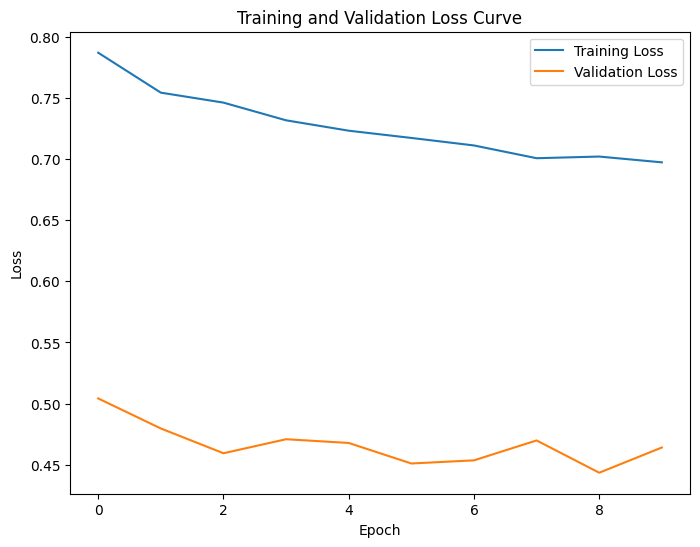

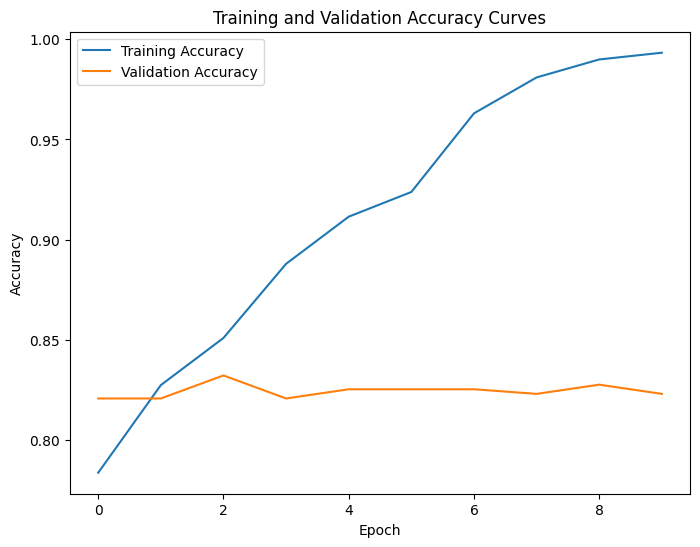

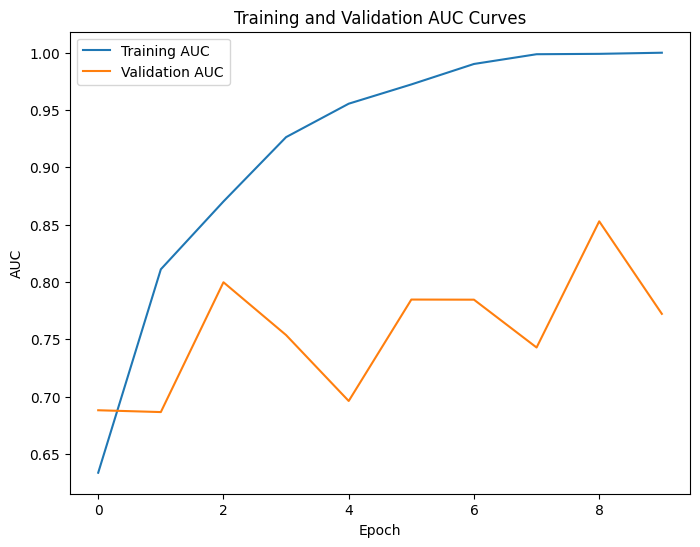

In [56]:
import matplotlib.pyplot as plt

# Plotting the training loss curve
plt.figure(figsize=(8, 6))
plt.plot(loss_list, label='Training Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curve')
plt.legend()
plt.show()

# Plotting the training and testing accuracy curves
plt.figure(figsize=(8, 6))
plt.plot(acc_train_list, label='Training Accuracy')
plt.plot(acc_val_list, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Curves')
plt.legend()
plt.show()

# Plotting the training and testing accuracy curves
plt.figure(figsize=(8, 6))
plt.plot(auc_train_list, label='Training AUC')
plt.plot(auc_val_list, label='Validation AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.title('Training and Validation AUC Curves')
plt.legend()
plt.show()